In [1]:
import os
import sys
import time
os.environ['TF_ENABLE_ONEDNN_OPTS'] = str(0)

import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras  # tf.keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipyparams
import json

from test_utility import *

print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)
    
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

2023-07-04 16:27:42.193661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 16:27:42.378243: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-04 16:27:43.200448: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-04 16:27:43.200570: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object fi

<IPython.core.display.Javascript object>

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.10.1
keras.api._v2.keras 2.10.0


In [3]:
notebookName = None
try:
    notebookName = os.path.basename(globals()['__vsc_ipynb_file__'])
except:
    pass

if type(notebookName) == str and len(notebookName.split('.')) > 1:  # looks like running on VSCode
    pass
else:  # looks like running on a browser
    notebookName = ipyparams.notebook_name
assert type(notebookName) == str and len(notebookName.split('.')) > 2
notebookName = ".".join(notebookName.split('.')[:-2])   # -2: gets rid of train version and file extention.
print(notebookName)

data_model = notebookName  #"vm03.05.250.11.80.100.16.14.1"
assert len(notebookName.split('.')) >= 8

v4.05.300.11.70.eth.30.12


In [4]:
dir_data = "/mnt/data/Trading/"

#===================================================================== Dataset

Nx = 300 # ------------- test
Ny = 11
Ns = 5 #--------------------- test
BatchSize = 128 * 5 # 9

Shift = 4 # 0, 1, 2, 3, 4, 0, 1, 2, 3

CandleFile = "18-01-01-00-00-23-05-20-20-23-5m"
CandleFile2 = "23-05-19-00-05-23-06-22-02-40-5m"
CandleFile3 = "23-06-21-00-05-23-06-26-17-36-5m"
SmallSigma = 1
LargeSigma = 30
eFreeNoLog = True

shuffle_batch = 30  # Keep it small to speed up model loading.

dir_candles = os.path.join(dir_data, "Candles")

Volume_Volatility = 1
All_Field_Names = ['ClosePrice', 'BaseVolume', 'BuyerBaseVolume']
min_true_candle_percent_x = 70
chosen_markets_x = []
chosen_fields_names_x = ['ClosePrice'] #, 'BaseVolume']
min_true_candle_percent_y = 70
assert min_true_candle_percent_x == min_true_candle_percent_y
chosen_markets_y = []
chosen_fields_names_y = ['ClosePrice']

target_market_names = None
# target_market_names = ['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT']
target_market_names = ['ETHUSDT']
tarket_market_top_percent = 15

Standardization = True
Kill_Irregulars = True  # ----------------- pls implement it
Time_into_X = True
Time_into_Y = False #
eFreeNoPlot = True

#======================================================================== Model

Num_Layers = 30 # Wow
Num_Heads = 1   # As we have a single GPU, and we want to a exhaustic attention.
Factor_FF = 4
repComplexity = 12  # Wower
Dropout_Rate = 0.  # You cannot change this once the model is built.

dir_Checkpoint = os.path.join(dir_data, "Checkpoints")
checkpoint_filepath = os.path.join(dir_Checkpoint, data_model)
dir_CSVLogs = os.path.join(dir_data, "CSVLogs")
csvLogger_filepath = os.path.join(dir_CSVLogs, data_model)

#======================================================================== Train

Epochs_Initial = 5000
HuberThreshold = 4.0
Checkpoint_Monitor = "val_loss"
EarlyStopping_Min_Monitor = "val_loss"
EarlyStopping_Patience = 5000

Optimizer = "adam"
LR_initial = 3e-7 # default: 1e-4
LR_rate = 0./100
LR_skip = 0

#=============================================================== Checksum

params = data_model.split('.')
assert int(params[1]) == int(CandleFile.split('-')[-1][:-1])
assert int(params[2]) == Nx
assert int(params[3]) == Ny
assert int(params[4]) == min_true_candle_percent_x
assert int(params[6]) == Num_Layers
assert int(params[7]) == repComplexity
targets = params[5]
if targets.isnumeric():
    assert target_market_names is None
    assert int(targets) == tarket_market_top_percent
else:
    for target in targets.split(','):
        assert (target+'usdt').upper() in target_market_names

#============================================================== Consistency
folders = [dir_data, dir_candles, dir_Checkpoint, dir_CSVLogs]
for folder in folders:
    if not os.path.isdir(folder):
        os.mkdir(folder)

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(gpus)
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # tf.config.experimental.set_virtual_device_configuration(
            #     gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)]) # why 5120?
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

mirrored_strategy = None
if len(gpus) > 1: 
    mirrored_strategy = tf.distribute.MirroredStrategy()
    LR_initial = LR_initial * len(gpus) * 3 / 4

# tf.config.experimental.set_virtual_device_configuration(
#     gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
#==================== Load candle and reports. Data structure depends on TradingBot ====================
Candles = np.load( os.path.join( dir_candles, "table-" + CandleFile + ".npy") )
with open( os.path.join( dir_candles, "reports-" + CandleFile + ".json"), "r") as f:
    reports = json.loads(f.read())

#==================== Load candle and reports. Data structure depends on TradingBot ====================
Candles2 = np.load( os.path.join( dir_candles, "table-" + CandleFile2 + ".npy") )
with open( os.path.join( dir_candles, "reports-" + CandleFile2 + ".json"), "r") as f:
    reports2 = json.loads(f.read())

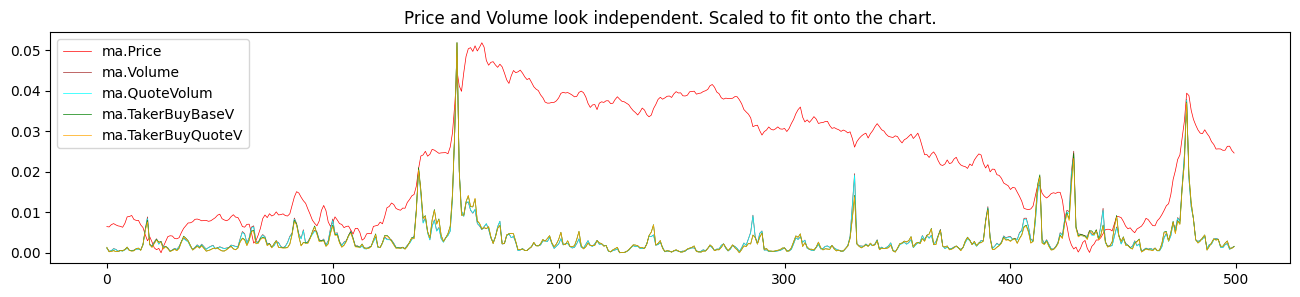

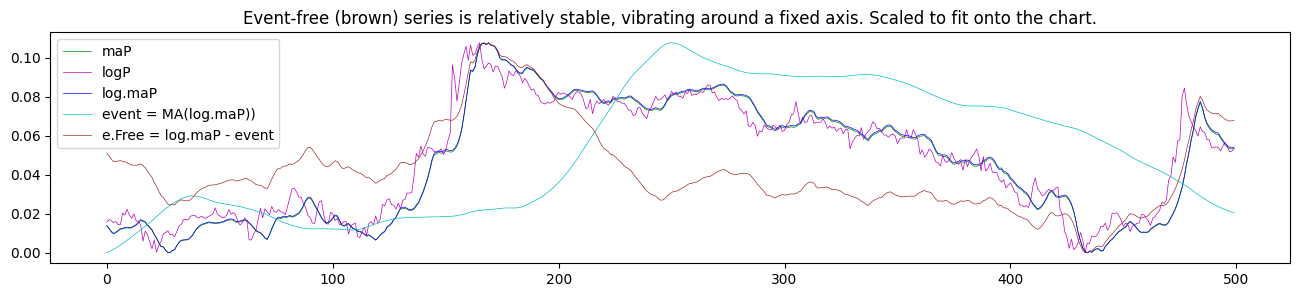

In [7]:
market = 5
Show_Price_Volume_10(Candles[market, :, :], 1, 1, 500)
Event_Free_Learning_Scheme_10(Candles[market, :, :], 3, 30, 500)

In [8]:
#==================== Format candles data ====================================
Candles, CandleMarks, all_market_names, x_indices, y_indices, \
chosen_market_names_x, chosen_field_names_x, chosen_market_names_y, chosen_field_names_y, \
chosen_market_names, chosen_field_names, \
target_markets_names, target_markets = \
get_formed_data_3(
        Candles, reports, All_Field_Names, 
        min_true_candle_percent_x, chosen_fields_names_x, min_true_candle_percent_y, chosen_fields_names_y,
        target_market_names, tarket_market_top_percent
)

In [9]:
print(Candles.shape)
print(CandleMarks.shape)
print(len(all_market_names))
print(x_indices)
print(y_indices)
print(chosen_market_names_x)
print(chosen_field_names_x)
print(chosen_market_names_y)
print(chosen_field_names_y)
print(chosen_market_names)
print(chosen_field_names)
print(target_markets_names)
print(target_markets)
print(len(chosen_market_names_x), len(chosen_market_names_y), len(target_markets_names))

(565633, 45, 1)
(565633, 45)
336
((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44), (0,))
((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44), (0,))
['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'XLMUSDT', 'IOTAUSDT', 'ONTUSDT', 'TRXUSDT', 'ETCUSDT', 'ICXUSDT', 'NULSUSDT', 'VETUSDT', 'LINKUSDT', 'WAVESUSDT', 'ONGUSDT', 'HOTUSDT', 'ZILUSDT', 'ZRXUSDT', 'FETUSDT', 'BATUSDT', 'XMRUSDT', 'ZECUSDT', 'IOSTUSDT', 'CELRUSDT', 'DASHUSDT', 'OMGUSDT', 'THETAUSDT', 'ENJUSDT', 'MATICUSDT', 'ATOMUSDT', 'TFUELUSDT', 'ONEUSDT', 'FTMUSDT', 'ALGOUSDT', 'DOGEUSDT', 'DUSKUSDT', 'ANKRUSDT', 'WINUSDT', 'COSUSDT', 'COCOSUSDT']
['ClosePrice']
['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT

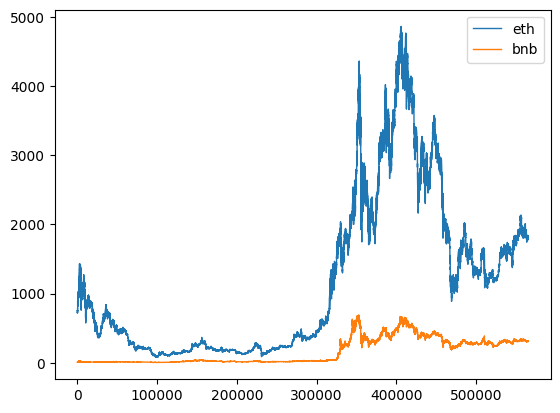

In [10]:
market = all_market_names.index("ETHUSDT")
plt.plot(Candles[:, market, 0], label='eth', linewidth=1)
market = all_market_names.index("BNBUSDT")
plt.plot(Candles[:, market, 0], label='bnb', linewidth=1)
plt.legend()
plt.show()

In [11]:
Candles2, CandleMarks2, missing_names2 = get_conformed_data_3(
    Candles2, reports2, chosen_market_names,
    All_Field_Names, chosen_field_names
 )

missing_markets ['COCOSUSDT']


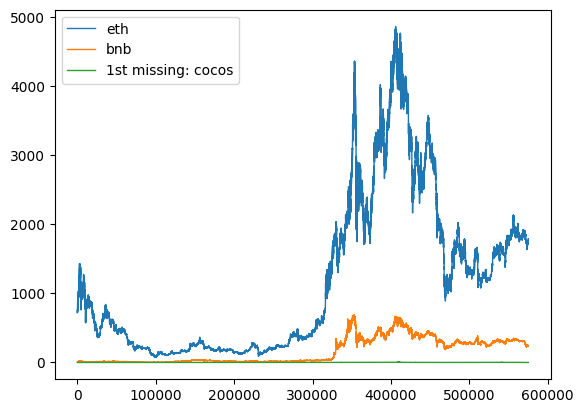

In [12]:
market = all_market_names.index("ETHUSDT")
joined = np.concatenate([Candles[:, market, 0], Candles2[:, market, 0]], axis=0)
plt.plot(joined, label='eth', linewidth=1)
market = all_market_names.index("BNBUSDT")
joined = np.concatenate([Candles[:, market, 0], Candles2[:, market, 0]], axis=0)
plt.plot(joined, label='bnb', linewidth=1)
if len(missing_names2) > 0:
    market = all_market_names.index(missing_names2[0])
    joined = np.concatenate([Candles[:, market, 0], Candles2[:, market, 0]], axis=0)
    plt.plot(joined, label="1st missing: " + missing_names2[0][:-len('USDT')].lower(), linewidth=1)
plt.legend()
plt.show()

In [13]:
#=========================== Get time features ======================
start_ts, interval_s, timestamps_abs, Times = get_joint_time_features_2(CandleFile, Candles.shape[0], Candles.dtype)

# start_ts2, _, timestamps_abs2, Times2 = get_joint_time_features_2(CandleFile2, Candles2.shape[0], Candles2.dtype)
# assert timestamps_abs2[0] - timestamps_abs[-1] == interval_s

In [14]:
# print(Candles.shape, Times.shape)
# print(timestamps_abs[:5])
# print(Candles2.shape, Times2.shape)
# print(timestamps_abs2[:5])
# # print(Times[:5])    # Agnostic of restart of this training notebook.

In [15]:
#========================= Get sample anchors ==============================
sample_anchors_t, sample_anchors_v = get_sample_anchors_3(Candles, Nx, Ny, Ns, seed=523)
print(sample_anchors_t.shape, sample_anchors_v.shape)
print(sample_anchors_t[:5])
assert sample_anchors_t[0] == 366760 
assert sample_anchors_t[1] == 118030

sample_anchors_t2, sample_anchors_v2 = get_sample_anchors_3(Candles2, Nx, Ny, Ns, seed=523)
print(sample_anchors_t2.shape, sample_anchors_v2.shape)
print(sample_anchors_t2[:5])
assert sample_anchors_t2[0] == 5365 
assert sample_anchors_t2[1] == 8585

(79144,) (33920,)
[366760 118030 416155  82070 167580]
(1286,) (552,)
[5365 8585 8675 5830 3415]


In [16]:
JointCandles, JointMarks, sample_anchors_t, sample_anchors_v = \
    get_joint_data(
        Candles, CandleMarks, sample_anchors_t, sample_anchors_v,
        Candles2, CandleMarks2, sample_anchors_t2, sample_anchors_v2
    )

(575137, 45, 1)
565315
[570680 573900 573990 571145 568730]
(80430,) (34472,)


In [17]:
print(JointCandles.shape)
print(sample_anchors_t.shape, sample_anchors_v.shape)

(575137, 45, 1)
(80430,) (34472,)


In [18]:
start_ts, interval_s, timestamps_abs, JointTimes = get_joint_time_features_2(CandleFile, JointCandles.shape[0], JointCandles.dtype)
size_time = Times.shape[1]

In [19]:
#======================== Get event-free data ========================

org_length = JointCandles.shape[0]
JointCandles, JointMarks, JointTimes = get_eventfree_data(
    JointCandles, JointMarks, JointTimes,
    SmallSigma, LargeSigma, all_market_names, chosen_market_names, 
    All_Field_Names, chosen_field_names,
    eFreeNoLog, eFreeNoPlot, Volume_Volatility
)

In [20]:
assert JointCandles.shape[0] == JointMarks.shape[0]
assert JointCandles.shape[0] == JointTimes.shape[0]
print(JointCandles.shape, CandleMarks.shape, JointTimes.shape, org_length-JointCandles.shape[0])
# print(Candles[-3:]) # Agnostic of restart of this training notebook.

(575046, 45, 1) (565633, 45) (575046, 4) 91


In [21]:
#========================= Standardize data ============================
Standard = None
if Standardization:
    JointCandles, Standard = standardize_2(JointCandles)
# print(Candles[-3:]) # Agnostic of restart of this training notebook.

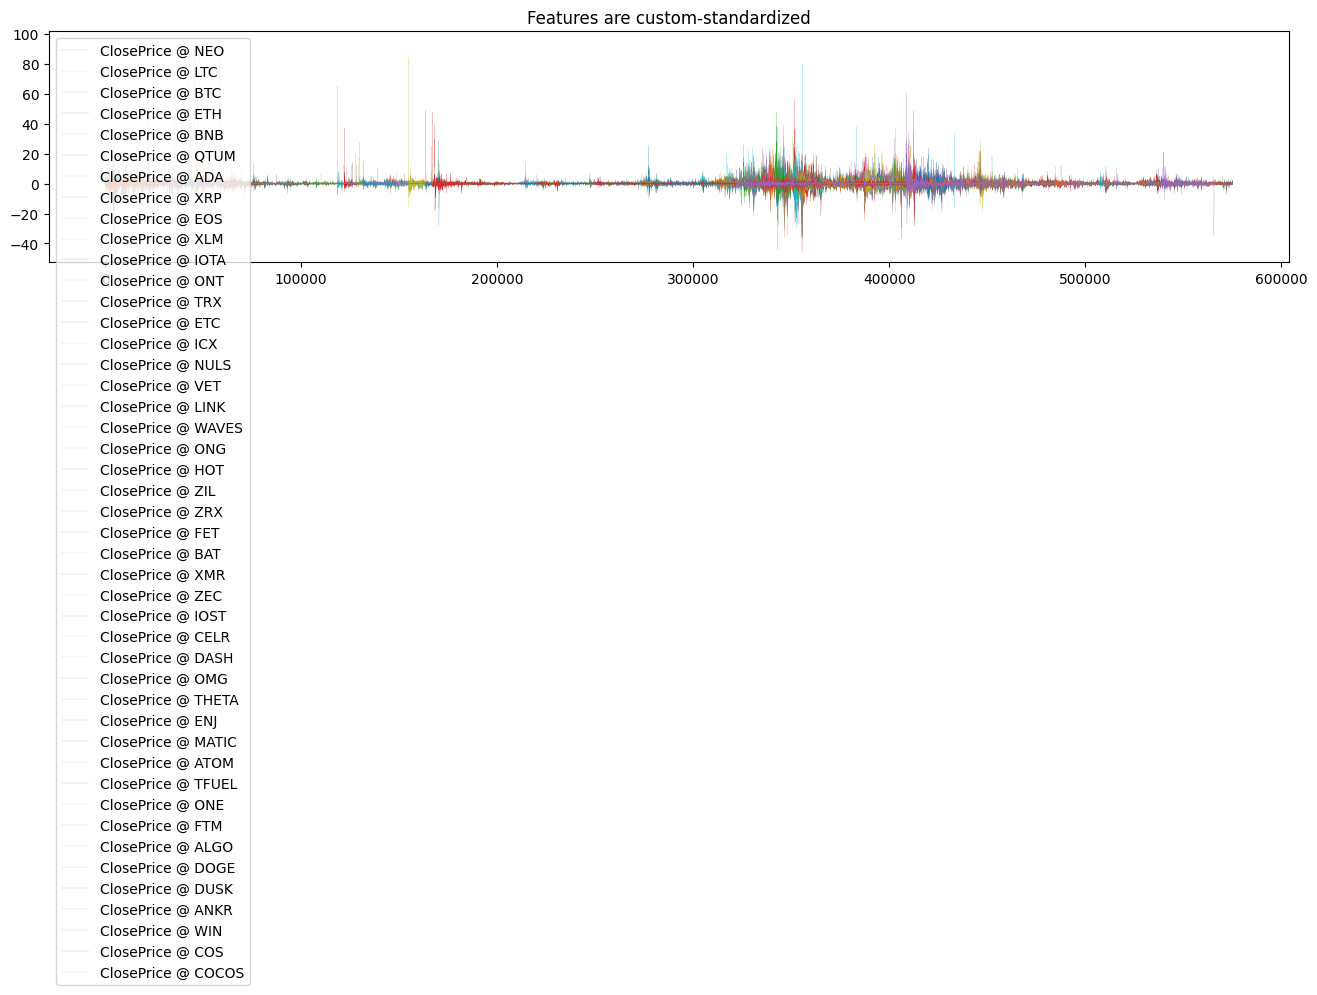

In [22]:
fig = plt.figure(figsize=(16,3))
ax = fig.add_subplot(111)
ax.set_title("Features are custom-standardized" if Standardization else "Features are not standardized")
for market in range(JointCandles.shape[1]):
    for field in range(JointCandles.shape[2]):
        ax.plot(JointCandles[:, market, field], label = "{} @ {}".format(All_Field_Names[field], all_market_names[market][:-len('USDT')]), lw=0.1)
ax.legend(loc = 'upper left')
plt.show()

In [23]:
ds_train, ds_valid, dx, dy = \
get_datasets_3(
    JointCandles, Time_into_X, Time_into_Y, JointTimes, 
    sample_anchors_t, sample_anchors_v,
    Nx, x_indices, Ny, y_indices, size_time, target_markets, Shift,
    BatchSize, shuffle_batch, shuffle=(len(gpus)<=1)
)

2023-07-04 16:28:46.609703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 16:28:47.283277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38239 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [24]:
model = None

if mirrored_strategy is None:
    model = build_model_3(
        dx, dy, Num_Layers, Num_Heads, Factor_FF, repComplexity, Dropout_Rate,
        HuberThreshold, Optimizer, initial=LR_initial, rate=LR_rate, skip=LR_skip
    )
else:
    with mirrored_strategy.scope():
        model = build_model_3(
            dx, dy, Num_Layers, Num_Heads, Factor_FF, repComplexity, Dropout_Rate,
            HuberThreshold, Optimizer, initial=LR_initial, rate=LR_rate, skip=LR_skip
        )

Loading a checkpoint...done


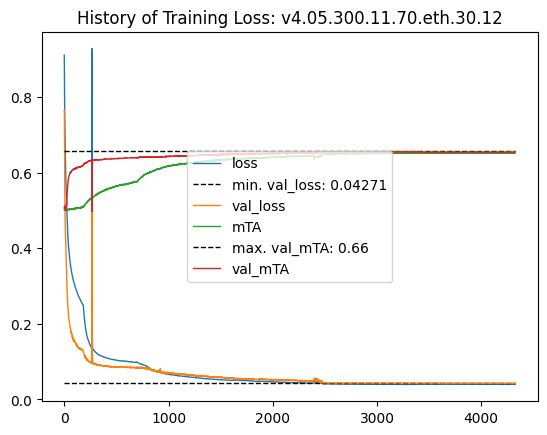

In [25]:
callbacks = get_callbacks(
    checkpoint_filepath, Checkpoint_Monitor, 
    csvLogger_filepath, 
    EarlyStopping_Min_Monitor, EarlyStopping_Patience
)
try:
    model.load_weights(checkpoint_filepath)
    print("Loading a checkpoint...done")
except:
    print("No chekkpoint to load. Fitting initailly...")
    model.fit(
        ds_train, # x and y_true
        validation_data=ds_valid,
        epochs=1, #Epochs_Initial,
        callbacks=callbacks
    )
try:
    columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
    plot_csv_train_history(csvLogger_filepath, columns, title=data_model)
except:
    pass

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 candle_input_x (InputLayer)    [(None, None, 50)]   0           []                               
                                                                                                  
 candle_input_y (InputLayer)    [(None, None, 50)]   0           []                               
                                                                                                  
 trans (ConTransformer)         (None, None, 50)     2638950     ['candle_input_x[0][0]',         
                                                                  'candle_input_y[0][0]']         
                                                                                                  
Total params: 2,638,950
Trainable params: 2,638,950
Non-trainable params: 0
__________________

In [ ]:
model.fit(
    ds_train, # x and y_true
    validation_data=ds_valid,
    epochs=Epochs_Initial,
    callbacks=callbacks
)

Epoch 1/5000


2023-07-04 16:30:35.096837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 14814 of 19200
2023-07-04 16:30:38.042542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-07-04 16:30:39.384864: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-04 16:30:40.080452: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


126/126 [==============================] - ETA: 0s - loss: 0.0398 - mTA: 0.6520

2023-07-04 16:33:14.929454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 14688 of 19200
2023-07-04 16:33:17.957713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


126/126 [==============================] - 278s 1s/step - loss: 0.0398 - mTA: 0.6520 - val_loss: 0.0430 - val_mTA: 0.6549
Epoch 2/5000
126/126 [==============================] - 154s 1s/step - loss: 0.0398 - mTA: 0.6521 - val_loss: 0.0430 - val_mTA: 0.6549
Epoch 3/5000
126/126 [==============================] - 154s 1s/step - loss: 0.0398 - mTA: 0.6516 - val_loss: 0.0428 - val_mTA: 0.6547
Epoch 4/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0398 - mTA: 0.6516 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 5/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0398 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 6/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0398 - mTA: 0.6519 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 7/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0398 - mTA: 0.6519 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 8/5000
126/126 [==============================] - 150s 1s/step

126/126 [==============================] - 149s 1s/step - loss: 0.0398 - mTA: 0.6518 - val_loss: 0.0430 - val_mTA: 0.6549
Epoch 62/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0398 - mTA: 0.6522 - val_loss: 0.0430 - val_mTA: 0.6546
Epoch 63/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0398 - mTA: 0.6523 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 64/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0398 - mTA: 0.6524 - val_loss: 0.0428 - val_mTA: 0.6548
Epoch 65/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0398 - mTA: 0.6517 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 66/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0398 - mTA: 0.6518 - val_loss: 0.0430 - val_mTA: 0.6547
Epoch 67/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0398 - mTA: 0.6519 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 68/5000
126/126 [==============================] - 149s 

126/126 [==============================] - 149s 1s/step - loss: 0.0398 - mTA: 0.6518 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 122/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0398 - mTA: 0.6517 - val_loss: 0.0429 - val_mTA: 0.6550
Epoch 123/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0398 - mTA: 0.6519 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 124/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0398 - mTA: 0.6523 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 125/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0397 - mTA: 0.6519 - val_loss: 0.0430 - val_mTA: 0.6547
Epoch 126/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0397 - mTA: 0.6519 - val_loss: 0.0430 - val_mTA: 0.6547
Epoch 127/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0398 - mTA: 0.6519 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 128/5000
126/126 [==============================] 

Epoch 181/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0397 - mTA: 0.6517 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 182/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0398 - mTA: 0.6525 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 183/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0397 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 184/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0397 - mTA: 0.6519 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 185/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0397 - mTA: 0.6524 - val_loss: 0.0428 - val_mTA: 0.6546
Epoch 186/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0397 - mTA: 0.6521 - val_loss: 0.0430 - val_mTA: 0.6548
Epoch 187/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0397 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 188/5000
126/126 [=================

Epoch 241/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6519 - val_loss: 0.0430 - val_mTA: 0.6547
Epoch 242/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0397 - mTA: 0.6517 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 243/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0397 - mTA: 0.6522 - val_loss: 0.0430 - val_mTA: 0.6548
Epoch 244/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0397 - mTA: 0.6517 - val_loss: 0.0428 - val_mTA: 0.6550
Epoch 245/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0397 - mTA: 0.6519 - val_loss: 0.0430 - val_mTA: 0.6546
Epoch 246/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0397 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6545
Epoch 247/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0397 - mTA: 0.6518 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 248/5000
126/126 [=================

Epoch 301/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0397 - mTA: 0.6522 - val_loss: 0.0428 - val_mTA: 0.6548
Epoch 302/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6518 - val_loss: 0.0428 - val_mTA: 0.6549
Epoch 303/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0397 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 304/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 305/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0397 - mTA: 0.6525 - val_loss: 0.0428 - val_mTA: 0.6545
Epoch 306/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0397 - mTA: 0.6523 - val_loss: 0.0430 - val_mTA: 0.6548
Epoch 307/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6519 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 308/5000
126/126 [=================

Epoch 361/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 362/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 363/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6521 - val_loss: 0.0430 - val_mTA: 0.6546
Epoch 364/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0397 - mTA: 0.6520 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 365/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6520 - val_loss: 0.0429 - val_mTA: 0.6545
Epoch 366/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6519 - val_loss: 0.0428 - val_mTA: 0.6548
Epoch 367/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6515 - val_loss: 0.0430 - val_mTA: 0.6548
Epoch 368/5000
126/126 [=================

Epoch 421/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6516 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 422/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6516 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 423/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6517 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 424/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6514 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 425/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6524 - val_loss: 0.0430 - val_mTA: 0.6547
Epoch 426/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 427/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6520 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 428/5000
126/126 [=================

Epoch 481/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 482/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6525 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 483/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6525 - val_loss: 0.0430 - val_mTA: 0.6547
Epoch 484/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6519 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 485/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6524 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 486/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6520 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 487/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0396 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 488/5000
126/126 [=================

Epoch 541/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6519 - val_loss: 0.0430 - val_mTA: 0.6547
Epoch 542/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6553
Epoch 543/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6524 - val_loss: 0.0429 - val_mTA: 0.6550
Epoch 544/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6551
Epoch 545/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6522 - val_loss: 0.0428 - val_mTA: 0.6551
Epoch 546/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6527 - val_loss: 0.0428 - val_mTA: 0.6547
Epoch 547/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6515 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 548/5000
126/126 [=================

Epoch 601/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 602/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6516 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 603/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6523 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 604/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 605/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6524 - val_loss: 0.0429 - val_mTA: 0.6550
Epoch 606/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0396 - mTA: 0.6520 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 607/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6525 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 608/5000
126/126 [=================

Epoch 661/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6544
Epoch 662/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 663/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 664/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6523 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 665/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6523 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 666/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6526 - val_loss: 0.0430 - val_mTA: 0.6545
Epoch 667/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6523 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 668/5000
126/126 [=================

Epoch 721/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6550
Epoch 722/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6522 - val_loss: 0.0428 - val_mTA: 0.6548
Epoch 723/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6524 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 724/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6518 - val_loss: 0.0428 - val_mTA: 0.6550
Epoch 725/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6521 - val_loss: 0.0428 - val_mTA: 0.6547
Epoch 726/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6523 - val_loss: 0.0428 - val_mTA: 0.6548
Epoch 727/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 728/5000
126/126 [=================

Epoch 781/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6522 - val_loss: 0.0428 - val_mTA: 0.6549
Epoch 782/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6522 - val_loss: 0.0428 - val_mTA: 0.6548
Epoch 783/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 784/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6523 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 785/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6546
Epoch 786/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0395 - mTA: 0.6521 - val_loss: 0.0428 - val_mTA: 0.6548
Epoch 787/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0394 - mTA: 0.6524 - val_loss: 0.0428 - val_mTA: 0.6551
Epoch 788/5000
126/126 [=================

Epoch 841/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6520 - val_loss: 0.0428 - val_mTA: 0.6547
Epoch 842/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0394 - mTA: 0.6519 - val_loss: 0.0428 - val_mTA: 0.6549
Epoch 843/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6524 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 844/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0394 - mTA: 0.6526 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 845/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6523 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 846/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0395 - mTA: 0.6527 - val_loss: 0.0428 - val_mTA: 0.6548
Epoch 847/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0394 - mTA: 0.6520 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 848/5000
126/126 [=================

Epoch 901/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0394 - mTA: 0.6523 - val_loss: 0.0428 - val_mTA: 0.6550
Epoch 902/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0394 - mTA: 0.6524 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 903/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0394 - mTA: 0.6520 - val_loss: 0.0429 - val_mTA: 0.6551
Epoch 904/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0394 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 905/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0394 - mTA: 0.6526 - val_loss: 0.0428 - val_mTA: 0.6552
Epoch 906/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0394 - mTA: 0.6522 - val_loss: 0.0428 - val_mTA: 0.6551
Epoch 907/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0394 - mTA: 0.6526 - val_loss: 0.0428 - val_mTA: 0.6551
Epoch 908/5000
126/126 [=================

Epoch 961/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0394 - mTA: 0.6519 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 962/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0394 - mTA: 0.6524 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 963/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0394 - mTA: 0.6525 - val_loss: 0.0428 - val_mTA: 0.6550
Epoch 964/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0394 - mTA: 0.6522 - val_loss: 0.0428 - val_mTA: 0.6547
Epoch 965/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0394 - mTA: 0.6525 - val_loss: 0.0428 - val_mTA: 0.6550
Epoch 966/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0394 - mTA: 0.6523 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 967/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0394 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6547
Epoch 968/5000
126/126 [=================

126/126 [==============================] - 152s 1s/step - loss: 0.0394 - mTA: 0.6524 - val_loss: 0.0428 - val_mTA: 0.6548
Epoch 1021/5000
126/126 [==============================] - 152s 1s/step - loss: 0.0394 - mTA: 0.6521 - val_loss: 0.0428 - val_mTA: 0.6547
Epoch 1022/5000
126/126 [==============================] - 152s 1s/step - loss: 0.0394 - mTA: 0.6523 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 1023/5000
126/126 [==============================] - 152s 1s/step - loss: 0.0394 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 1024/5000
126/126 [==============================] - 153s 1s/step - loss: 0.0394 - mTA: 0.6527 - val_loss: 0.0428 - val_mTA: 0.6548
Epoch 1025/5000
126/126 [==============================] - 152s 1s/step - loss: 0.0394 - mTA: 0.6520 - val_loss: 0.0429 - val_mTA: 0.6551
Epoch 1026/5000
126/126 [==============================] - 152s 1s/step - loss: 0.0394 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6550
Epoch 1027/5000
126/126 [=========================

126/126 [==============================] - 152s 1s/step - loss: 0.0394 - mTA: 0.6524 - val_loss: 0.0428 - val_mTA: 0.6547
Epoch 1080/5000
126/126 [==============================] - 152s 1s/step - loss: 0.0394 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6550
Epoch 1081/5000
126/126 [==============================] - 152s 1s/step - loss: 0.0394 - mTA: 0.6521 - val_loss: 0.0428 - val_mTA: 0.6547
Epoch 1082/5000
126/126 [==============================] - 152s 1s/step - loss: 0.0394 - mTA: 0.6524 - val_loss: 0.0428 - val_mTA: 0.6549
Epoch 1083/5000
126/126 [==============================] - 152s 1s/step - loss: 0.0394 - mTA: 0.6520 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 1084/5000
126/126 [==============================] - 152s 1s/step - loss: 0.0394 - mTA: 0.6520 - val_loss: 0.0428 - val_mTA: 0.6549
Epoch 1085/5000
126/126 [==============================] - 152s 1s/step - loss: 0.0394 - mTA: 0.6525 - val_loss: 0.0428 - val_mTA: 0.6549
Epoch 1086/5000
126/126 [=========================

126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6528 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 1139/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0394 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6550
Epoch 1140/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6519 - val_loss: 0.0428 - val_mTA: 0.6547
Epoch 1141/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6526 - val_loss: 0.0428 - val_mTA: 0.6551
Epoch 1142/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0394 - mTA: 0.6524 - val_loss: 0.0428 - val_mTA: 0.6547
Epoch 1143/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6527 - val_loss: 0.0428 - val_mTA: 0.6548
Epoch 1144/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6523 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 1145/5000
126/126 [=========================

126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6526 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 1198/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0394 - mTA: 0.6521 - val_loss: 0.0428 - val_mTA: 0.6550
Epoch 1199/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6525 - val_loss: 0.0427 - val_mTA: 0.6551
Epoch 1200/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6551
Epoch 1201/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6525 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 1202/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6523 - val_loss: 0.0428 - val_mTA: 0.6550
Epoch 1203/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6523 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 1204/5000
126/126 [=========================

126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6516 - val_loss: 0.0428 - val_mTA: 0.6551
Epoch 1257/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6521 - val_loss: 0.0429 - val_mTA: 0.6551
Epoch 1258/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6548
Epoch 1259/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6526 - val_loss: 0.0428 - val_mTA: 0.6548
Epoch 1260/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6527 - val_loss: 0.0428 - val_mTA: 0.6550
Epoch 1261/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6522 - val_loss: 0.0429 - val_mTA: 0.6550
Epoch 1262/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6526 - val_loss: 0.0428 - val_mTA: 0.6548
Epoch 1263/5000
126/126 [=========================

126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6525 - val_loss: 0.0427 - val_mTA: 0.6551
Epoch 1316/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6520 - val_loss: 0.0428 - val_mTA: 0.6550
Epoch 1317/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6520 - val_loss: 0.0429 - val_mTA: 0.6550
Epoch 1318/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6528 - val_loss: 0.0429 - val_mTA: 0.6551
Epoch 1319/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6522 - val_loss: 0.0428 - val_mTA: 0.6551
Epoch 1320/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6525 - val_loss: 0.0428 - val_mTA: 0.6552
Epoch 1321/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6526 - val_loss: 0.0429 - val_mTA: 0.6551
Epoch 1322/5000
126/126 [=========================

126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6523 - val_loss: 0.0428 - val_mTA: 0.6550
Epoch 1375/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0392 - mTA: 0.6523 - val_loss: 0.0428 - val_mTA: 0.6550
Epoch 1376/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6519 - val_loss: 0.0428 - val_mTA: 0.6549
Epoch 1377/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0392 - mTA: 0.6520 - val_loss: 0.0429 - val_mTA: 0.6550
Epoch 1378/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6526 - val_loss: 0.0428 - val_mTA: 0.6548
Epoch 1379/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6528 - val_loss: 0.0428 - val_mTA: 0.6552
Epoch 1380/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6522 - val_loss: 0.0428 - val_mTA: 0.6551
Epoch 1381/5000
126/126 [=========================

126/126 [==============================] - 150s 1s/step - loss: 0.0392 - mTA: 0.6530 - val_loss: 0.0429 - val_mTA: 0.6552
Epoch 1434/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0393 - mTA: 0.6526 - val_loss: 0.0429 - val_mTA: 0.6550
Epoch 1435/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0392 - mTA: 0.6525 - val_loss: 0.0428 - val_mTA: 0.6549
Epoch 1436/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0392 - mTA: 0.6519 - val_loss: 0.0428 - val_mTA: 0.6551
Epoch 1437/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0392 - mTA: 0.6523 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 1438/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0392 - mTA: 0.6523 - val_loss: 0.0428 - val_mTA: 0.6549
Epoch 1439/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0392 - mTA: 0.6528 - val_loss: 0.0428 - val_mTA: 0.6552
Epoch 1440/5000
126/126 [=========================

126/126 [==============================] - 149s 1s/step - loss: 0.0392 - mTA: 0.6520 - val_loss: 0.0429 - val_mTA: 0.6554
Epoch 1493/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6523 - val_loss: 0.0428 - val_mTA: 0.6549
Epoch 1494/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6525 - val_loss: 0.0428 - val_mTA: 0.6550
Epoch 1495/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0392 - mTA: 0.6527 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 1496/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0393 - mTA: 0.6529 - val_loss: 0.0428 - val_mTA: 0.6549
Epoch 1497/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0392 - mTA: 0.6524 - val_loss: 0.0429 - val_mTA: 0.6551
Epoch 1498/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0392 - mTA: 0.6523 - val_loss: 0.0429 - val_mTA: 0.6549
Epoch 1499/5000
126/126 [=========================

126/126 [==============================] - 149s 1s/step - loss: 0.0392 - mTA: 0.6523 - val_loss: 0.0427 - val_mTA: 0.6550
Epoch 1552/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0392 - mTA: 0.6525 - val_loss: 0.0429 - val_mTA: 0.6550
Epoch 1553/5000
126/126 [==============================] - 150s 1s/step - loss: 0.0392 - mTA: 0.6518 - val_loss: 0.0427 - val_mTA: 0.6549
Epoch 1554/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0392 - mTA: 0.6522 - val_loss: 0.0428 - val_mTA: 0.6552
Epoch 1555/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0392 - mTA: 0.6528 - val_loss: 0.0429 - val_mTA: 0.6550
Epoch 1556/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0392 - mTA: 0.6520 - val_loss: 0.0429 - val_mTA: 0.6551
Epoch 1557/5000
126/126 [==============================] - 149s 1s/step - loss: 0.0392 - mTA: 0.6523 - val_loss: 0.0429 - val_mTA: 0.6550
Epoch 1558/5000
126/126 [=========================

In [ ]:
columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
plot_csv_train_history(csvLogger_filepath, columns, title=data_model)

# Inference

In [ ]:
#==================== Load candle and reports. Data structure depends on TradingBot ====================
Candles3 = np.load( os.path.join( dir_candles, "table-" + CandleFile3 + ".npy") )
with open( os.path.join( dir_candles, "reports-" + CandleFile3 + ".json"), "r") as f:
    reports3 = json.loads(f.read())

In [ ]:
Candles3, CandleMarks3, missing_names3 = get_conformed_data_3(
    Candles3, reports3, chosen_market_names,
    All_Field_Names, chosen_field_names
 )

In [ ]:
print(Candles3.shape)

In [ ]:
start_ts3, interval_s, timestamps_abs3, Times3 = \
    get_standalone_time_features(CandleFile, CandleFile3, Candles3.shape[0], Candles3.dtype)

In [ ]:
#======================== Get event-free data ========================

org_length = Candles3.shape[0]
Candles3, CandleMarks3, Times3 = get_eventfree_data(
    Candles3, CandleMarks3, Times3,
    SmallSigma, LargeSigma, all_market_names, chosen_market_names, 
    All_Field_Names, chosen_field_names,
    eFreeNoLog, eFreeNoPlot, Volume_Volatility
)

In [ ]:
if Standardization:
    Candles3 = standardize_observation(Candles3, Standard)

In [ ]:
# del Candles, Candles2

step = Ny
pred_base_ts = timestamps_abs3[ np.array(range(timestamps_abs3.shape[0]-1, 0, -step) , dtype=np.int64) ]
Candles3_padded = np.pad(Candles3, [[0, Ny], [0,0], [0,0]], constant_values=0)
print(Candles3.shape, Candles3_padded.shape)
Times3_padded = np.pad(Times3, [[0, Ny], [0,0]], constant_values=0) # pad with 0 assuming Time_into_Y == False
_sample_anchors_t = np.flip(np.array(range(Candles3_padded.shape[0] - Nx - Ny, 0, -step), dtype=np.int64), axis=0)
_sample_anchors_v = np.array([], dtype=np.int64)
_shift = 0; _batchSize = BatchSize ; _shuffle_batch = 0; _shuffle = False
_ds_train, _, _, _ = \
get_datasets_3(
    Candles3_padded, Time_into_X, Time_into_Y, Times3_padded,
    _sample_anchors_t, _sample_anchors_v,
    Nx, x_indices, Ny, y_indices, size_time, target_markets, _shift,
    _batchSize, _shuffle_batch, shuffle=_shuffle, cache=False
)

In [ ]:
# for anchor_id in range(_sample_anchors_t.shape[0]):
#     print(anchor_id)
#     size_y = get_timepoint_size(y_indices)
#     anchor = _sample_anchors_t[anchor_id]
#     y_anchor = Candles3_padded[anchor, y_indices[0], y_indices[1] ]
#     time_anchor = Times3_padded[anchor]

#     b_cnt = anchor_id // _batchSize
#     for ((x, y), _) in _ds_train:
#         if b_cnt == 0:
#             x = x.numpy(); y = y.numpy()
#             assert (x[anchor_id % _batchSize, 1, : size_y] == y_anchor).all()  # (batch, Nx, dx)
#             assert (x[anchor_id % _batchSize, 1, size_y : -1] == time_anchor).all()  # (batch, Nx, dx) time_features
#             break
#         else:
#             b_cnt -= 1

In [ ]:
anchor_start = _sample_anchors_t[0]

Candles3_pred = Candles3_padded.copy() # np.zeros_like(Candles3_padded, dtype=Candles3_padded.dtype)
Candles3_pred = np.zeros_like(Candles3_padded, dtype=Candles3_padded.dtype)

anchor_id = 0
size_y = get_timepoint_size(y_indices)
for ((x, y), _) in _ds_train: # must loop Ny + 1
    print(anchor_id, end=' ')
    x = x.numpy(); y = y.numpy(); y[:] = 0.0  # (batch, Ny+1, dy)  y[:, 0, :] == Start
    # print(x.shape, y.shape)
    for i in range(y.shape[1]):
        pred = model((x, y))    # pred: (batch, Ny+1, dy)
        pred = pred.numpy()
        y[:, i] = pred[:, i]

    for b in range(x.shape[0]):
        anchor = _sample_anchors_t[anchor_id]
        print(anchor, end=' ')
        Candles3_pred[anchor + Nx: anchor + Nx + Ny] = y[b, :-1, :size_y].reshape((Ny, len(y_indices[0]), len(y_indices[1])))
        # print(b, anchor_id, anchor)
        anchor_id += 1

In [ ]:
market_name = "ETHUSDT"
market_id = all_market_names.index(market_name)
field_id = 0
print(market_id)

points = tuple(range(Candles3_padded.shape[0]))
lw = 0.5
plt.plot(Candles3_padded[:, market_id, field_id ], label='true', lw=lw)
plt.plot(Candles3_pred[:, market_id, field_id ], label='pred', lw=lw)
plt.legend()
plt.title(market_name)
plt.show()

In [ ]:
print(timestamps_abs3[-1])
print(datetime.fromtimestamp(timestamps_abs3[-1]))